In [74]:
#if band value == -999.0 no magnitude is given
import warnings
warnings.filterwarnings("ignore")
#LATER: Add z-y from mamajek or so...
import numpy as np
import random
import pandas as pd

import matplotlib.pyplot as plt
import specmatchemp.library
import specmatchemp.plots as smplot
from scipy.integrate import trapz
from scipy.constants import pi, h, c, k

wavmin, wavmax = 3480., 9700.
lib = specmatchemp.library.read_hdf(wavlim=[wavmin,wavmax])

def import_pickles98():
    
    '''
    
    Read in the lookup table for spectral classes into a dataframe.
    
    Column names:
    spec_class, lum_class, u_g, g_r, r_i, i_z, z_J, J_H, H_K, Jmag_abs
    
    '''
    
    df = pd.read_csv('share/spectralclasses_padded.csv',skiprows=49)
    df.lum_class = df.lum_class.str.strip()
    df.spec_class = df.spec_class.str.strip()
    return df

def insert_spec_class(lookup_spec,c1,c2,index,l='V',debug=False):
    
    '''
    
    Looks up the best fitting spectral class for a given _c1_-_c2_ in color _index_ 
    within luminosity class _l_ in the _lookup_spec_ table for a given object.
    
    Return:
    
    idx: indices of best fitting rows in lookup_spec
    
    '''
    
    if c1!=-999.0 and c2!=-999.0:
        
        try:

            color = c1-c2
            lookup = lookup_spec[lookup_spec['lum_class'].str.strip() == l]
            spec_class = lookup_spec.spec_class
            color_list = lookup_spec[index]
            idx = []
            try:
                for i, row in lookup.iterrows():
                    left = color_list[i]
                    right = color_list[i+1]
                    if left < color < right:    
                        if abs(color - left) < abs(color - right):
                            idx.append(i)
                        else: idx.append(i+1)
            except IndexError:
                pass

            if len(idx) != 0:
                spec_classes = [spec_class[j] for j in idx]

            else:
                spec_classes = 'color index too high or low to be assigned'
                'to spectral class in this luminosity class'
            all_spec_classes = [spec_classes,l]

        except (KeyError, TypeError):
            idx = []
            all_spec_classes = ['None',l]
            if debug == True:            
                print('no entries for color index {}.\n'.format(index))

    else:
        idx=[]
    
    return idx


def dprint(str,debug):
    
    '''
    
    Prints out all help text snippets where the debug flag is passed.
    
    '''
    
    if debug==True:
        print(str)
    return

def display(opt,d,debug):
    
    '''
    
    Displays additional information about a resulting 
    combo _opt_ of spectral classes given some colors 
    and approximates their likelihood by the mutual distance
    between the rows _d_. Conditional on the _debug_ flag being passed.
    
    '''
    
    dprint('New combination: {}'.format(opt),debug)
    dprint('This combination has distance {}'.format(d),debug)
    
    return

def optimize_spec_class(colors,lookup_spec,debug=False):
    
    '''
    
    THIS IS A VERY LOW-LEVEL IMPLEMENTATION. FUTURE VERSION SHOULD USE PANDAS.
    
    Input:
    colors: series with J,H,K,g,r,i,z,y colors
    lookup_spec: lookup data frame with spectral and luminosity classes for different colors
    
    '''
    
    indices={'J_H':('J','H'),'H_K':('H','K'),'Jmag_abs':'J','g_r':('gmag','rmag'),'r_i':('rmag','imag'),'i_z':('imag','zmag'),'z_y':('zmag','ymag')}
    #Different luminosity classes can occur
    #luminosity_classes={'I':0.01,'III':0.,'V':-0.01}
    
    #RESTRICT TO DWARFS
    #luminosity_classes={'V':-0.01}
 
    
    #Initialize the procedure:
    lum_opt=dict()
    minspread=10000
    lum_class='V'
    best_lum_class = lum_class
    best_spec_class='None'
    opt_backup=dict()
    
    dprint('These are the given colors: \n{}\n\n'.format(colors),debug=debug)
    
    #Construct the optimum spec class solution for each luminosity class:
 #   for lum_class, weight in luminosity_classes.items():
    dprint('-------------',debug)
    dprint(lum_class,debug)

    #initialize a list that contain the indices in order to compute the uncertainty on the estimate later
    spr=[]
    #initialize the color indices that are used in the end and their respective values
    color_results={}

    #Iterate over all color indices (j,h,k or g,r,i,z,y) to compute possible colors (e.g.: j-h or r-i)
    #This yields a list of possible spectral classes for each color since colors are not 
    #an unambiguous function of spectral class, i.e. several spectral classes can share the same color index
    for key,v in indices.items():

        if key == 'Jmag_abs':
            #Same goes for luminosity only. Jmag_abs values correspond to spectral classes, too:
            #idx returns the indices into the Pickles'98 table that correspond to spec classes:
            #all of this for the given luminosity class
            c = colors.get(v)
            idx = insert_spec_class(lookup_spec,c,0,key,l='V', debug=debug)
        else:
            #unpack the colors for each color index
            v1,v2 = v
            c1 = colors.get(v1)
            c2 = colors.get(v2)
            #idx returns the indices into the Pickles'98 table that correspond to spec classes:
            #all of this for the given luminosity class
            idx=insert_spec_class(lookup_spec,c1,c2,key,l='V', debug=debug)

        #So, for a certain color index name (key) there is a list of indices (idx) that fit into the Pickles'98 table
        color_results[key]=idx


    dprint(color_results,debug)

    #Now given a dict with different colors and possible spec classes for each of them we have to find the best combination
    #This is done by finding the combination which lies closest together within the table and hence has the least uncertainty

    #Initialize the a new possible optimum, that may later become the backup solution
    opt=dict()
    #Iterate over all colors and their possible classes to find the closest entries in the other color indices
    for key, value in color_results.items():
        #remove the regarded color index to avoid redundance
        rest_results=dict(color_results)
        del rest_results[key]
        #Iterate over all possible classes (index) for the given central color (key)
        for index in value:
            #add the associated color for the central index
            opt[key]=lookup_spec.spec_class[index]
            #add central index to the list of indices that should be clostest to each other among all given indices across all colors
            spr.append(index)
            #Init distance list for linear distances
            d=[]
            #Iterate over all other colors and find the indices of possible spectral classes that are closest to the chosen cetral one
            for key2, value2 in rest_results.items():
                #compute all the linear distances
                delta=[abs(x-index) for x in value2]
                if delta!=[]:
                    #find the minimum linear distance
                    dadd=min(delta)
                    d.append(dadd)
                    #find its corresponding index in Pickles'98 table
                    minind=value2[delta.index(dadd)]
                    #add the associated color
                    opt[key2]=lookup_spec.spec_class[minind]
                    #add to the list of indices that should be closest to each other
                    spr.append(minind)

            #distance calculation
            #The row number distance within a padded table is used as proxy to uncertainty
            #distance d is defined as the sum of distances to one of the rows in n-colored space
            d=np.sqrt(sum([x*x for x in d]))/len(color_results)

            #select this iteration if it yields a minimum in distance
            try:
                if d<mindist:
                    #output for debugging
                    display(opt,d,debug)
                    mindist=d
                    opt_backup=dict(opt)
                else:
                    #output for debugging
                    display(opt,d,debug)
                    dprint('Best solution has been found already, namely: {}'.format(opt_backup),debug)
                    opt.clear()
            #This error occurs if mindist has not yet been assigned
            except UnboundLocalError:
                #output for debugging
                display(opt,d,debug)
                mindist=d
                opt_backup=dict(opt)
        mindist=0
        del mindist
        #Assign a relative spread within the best solution weighted by the number of colors
        rel_spread=np.std(np.array(spr))
        #Calculate the mean index for the resulting spectral class
        mean=np.mean(np.array(spr))
        dprint('The standard deviation for the optimum solution in this luminosity class is {}'.format(rel_spread),debug)
        #Minimize the spread across all luminosity classes
        try:
            if rel_spread < minspread:
                minspread = rel_spread
                best_lum_class = lum_class
                best_spec_class = tab_spec.spec_class[int(np.rint(mean))]
        #This error occurs if rel_spread has not yet been assigned
        except UnboundLocalError:
            minspread=rel_spread
            best_lum_class=lum_class
            best_spec_class=tab_spec.spec_class[int(np.rint(mean))]
        #Summarize the results for all luminosity classes in one dict:
        lum_opt[lum_class]=[rel_spread,opt_backup]
        
    dprint('-------------------',debug)
    dprint('Best results for spectral class and luminosity class: L={} and spec={}.'.format(best_lum_class,best_spec_class),debug)
    dprint('',debug)
    
    return best_spec_class

def import_params(cluster,basics,debug=False):
    
    loc='share/'+cluster+'/'+cluster+'_parameter.csv'
    #params=open(loc)
    #param_dict=dict()
    #basics=params.readline()
    #basics=[u for u in basics[1:-2].split(', ')]

    
#     with open(loc) as params:
#         basics=params.readline()
#         basics=[u for u in basics[1:-2].split(', ')]
        
    params=pd.read_csv(loc)
    params['results']=pd.Series('NaN')
    params.set_index('EPIC',inplace=True)
    
    if debug == True:
        print('These are the parameters from the matching procedure\n\n{}\n'.format(params.head()))

    return params, basics

def optimize_spec_class_ID(oid,param_dict,tab_spec,debug=False):

    
    #ID,c_idx = param_dict.ID[oid], param_dict.color_set[oid]
    #c_idx = param_dict.color_set[oid]
    #colors = param_dict[list(param_dict.color_set[oid])].loc[oid]
    bsc = optimize_spec_class(param_dict.loc[oid],tab_spec,debug=debug)
    
    return bsc

def optimize_spec_class_all(param_dict, tab_spec, debug=False):
    
    for index, row in param_dict.iterrows():
        #blc,bsc,lum_opt=optimize_spec_class(row[list(row['color_set'])],tab_spec,c_idx=row['color_set'],debug=debug)
        bsc=optimize_spec_class(row,tab_spec,debug=debug)
        param_dict.results[index] = bsc
        
    return param_dict

def spec_class_hist(specs,cluster):

    counts = specs.results.value_counts()
    y = counts[:]

    plot = y.plot(kind = 'bar')
    fig = plot.get_figure()
    fig.savefig('docs/{}/{}_spec_Kp.jpg'.format(cluster,cluster),dpi=300)
    
    return

def CMD(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(19,5)):
    specs[color]=specs[cid1]-specs[cid2]
    plot = specs.plot(x=color,y=cid1,ylim=ylim,kind = 'scatter')
    fig = plot.get_figure()
    fig.savefig('docs/{}/{}_CMD_{}.jpg'.format(cluster,cluster,color),dpi=300)
    return

#----------------------------------------
#ENERGY CALC
#---------------------------------------


h*=1e7 # Planck constant in erg*s
c*=1e2 # light speed in cm/s
k*=1e7 # Boltzmann constant in erg/K

#Solution to nan-bug:
#https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def interpolate_nan(y):
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return

#End: Solution to nan_bug

def spectrum(T,wavmin=3480., wavmax=9700.,lib=lib):
    
    '''
    
    Returns the spectrum of a star at effective temperature T in wavelength range [wavmin,wavmax]
    Default range corresponds to Kepler response
    
    '''
    #loads library of spectra within wavelength range
    
    if T > 7000:
        print('{}K is hotter than 7000K.'.format(T))
        return lib.wav, []
    else: 

        #find the spectrum that fits T best
        Tmin = str(T-100.)
        Tmax = str(T+100.)
        cut = lib.library_params.query(Tmin+'<Teff<'+Tmax)    
        T_offer = zip(list(cut['Teff']), list(cut['lib_index']))
        T_minindex = min(T_offer, key = lambda t: abs(t[0]-T))[1]
        cut = cut.loc[T_minindex]
        #return the spectrum
        spec = lib.library_spectra[cut.lib_index,0,:]
        return lib.wav, spec.T

def kepler_spectrum(T):
    '''
    
    Convolves a blackbody of effective temperature T, 
    the spectrum of a dwarf star with corresponding spectral class,
    and the Kepler response function 
    to return the wavelength dependent flux of that star per area
    
    Input:
    T - effective temperatur in K
    
    Returns:
    Kp_flux in erg/cm*(cm**2)
    Kp_midwav in 
    
    
    '''
    Kp_wav, Kp_resp = np.loadtxt('spectra/Kepler_response.txt',unpack=True)
    Kp_wav*=10. #convert to angström for spectrum function
    #load the spectrum within a wavelength range that fits given T_eff best
    Spec_wav,Spec_flux = spectrum(T,min(list(Kp_wav)),max(list(Kp_wav)))
    #map Kepler response linearly into wavelengths given with the spectrum
    if Spec_flux == []:
        print('{}K is too hot for specmatch-emp.'.format(T))
        return [],[]
    else:
        Spec_flux = np.interp(Kp_wav,Spec_wav,Spec_flux)

        Kp_flux = np.empty(Kp_wav.shape[0]-1)
        Kp_midwav  = np.empty(Kp_wav.shape[0]-1)
        #calculate the flux of a star with given T_eff 
        #accounting for Kepler filter 
        #and the corresp. spectrum of that stellar type 
        try:
            for i, response in enumerate(Kp_resp):
                dlambda = (Kp_wav[i+1]-Kp_wav[i])*1e-8 #infin. element of wavelength in cm
                lambda_ = np.mean(Kp_wav[i:i+2])*1e-8 #wavelength in cm
                Kp_midwav[i] = lambda_

                Kp_flux[i] = Spec_flux[i] *response* 2. * h * c**2 / lambda_**5 / (np.exp(h * c / ( lambda_ * k * T ) ) - 1. ) 

        except IndexError:
            pass

        return Kp_midwav, Kp_flux

def plot_kepler_spectrum(T):

    wav,flux = kepler_spectrum(T)
    
    if flux == []:
        return print('No data for T = {}K'.format(T))
    else:
        plt.figure()
        plt.plot(wav*1e8, flux,color='green')
        plt.show()  
    return


    

def kepler_luminosity(T):
    
    '''
    Integrates the Kepler flux,
    multiplies by the area A=pi*(R**2),
    to obtain observed quiescent flux for an object
    
    Return:
    
    total Kepler luminosity in erg/s of a dwarf star with effective temperature T
    
    '''
    
    params=pd.read_csv('share/spec_class_Teff_mamajek.txt')
    
    #calculate Kepler spectrum of a dwarf star with temperature T

    wav,flux=kepler_spectrum(T)
    if flux == []:
        return print('{} is too hot'.format(T))
    else:
        #interpolate where nans occur
        interpolate_nan(wav)
        interpolate_nan(flux)

        #select the relevant columns from params
        radii_teff=params[['Teff','R_Rsun']]

        #find the entry in radii_teff which lies closest in terms of tempererature to T
        Tmin=min([abs(x-T) for x in radii_teff.Teff])+T

        #set index of data frame to be T_eff
        radii_teff.set_index('Teff',inplace=True)

        #select the radius of the given star with T_eff
        try:
            radius_cm=radii_teff.R_Rsun[Tmin]*6.96342e10 #stellar radius in cm
        except KeyError:
            radius_cm=radii_teff.R_Rsun[2.*T-Tmin]*6.96342e10 #stellar radius in cm

        return np.trapz(flux, wav)*pi*(radius_cm**2)

def spec_class_to_Teff(s):
    params=pd.read_csv('share/spec_class_Teff_mamajek.txt')
    #set index of data frame to be T_eff
    params.set_index('Teff',inplace=True)
    #find and return the T_eff that correspods to the given spectral class:
    try:
        return params[params.dwarf==s].index.values[0]
    except IndexError:
        return None
    
def Kp_to_Lum(df, dm, Kp='Kp'):
    df['Kp_abs'] = df[Kp]+dm
    #print(df.head())
    return

#-------------------------------
#FFD
#-------------------------------

def ED(start,stop,time,flux_model,flux_gap):
    start, stop = int(start),int(stop)
    time = np.asarray(time)[start:stop+1]
    model = np.asarray(flux_model)[start:stop+1]
    flux = np.asarray(flux_gap)[start:stop+1]
    residual = np.subtract(flux,model)
    flare = trapz(residual,time)
    quiet = trapz(model,time)
    ed = flare/quiet
    return ed


def import_flares(cluster, test, oid):
    
    objectid = str(oid)
    loc = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}'.format(cluster,test)
    myloc = loc + '_my_flares.txt'
    try:
        myflares = pd.read_csv(myloc, names= ['start','stop','istart','istop','comment'])
        #print(myflares.head())
    except OSError:
        #print('No by hand analysis available.')
        myflares = []
#    appaloc = loc + '.txt'
    appaflares = pd.read_csv('{}/{}_flux.csv'.format(loc,oid))#, names= ['time','flux_gap','error','flux_model'])
    #print(appaflares.head())
#    appaidsloc = loc +'_flares.txt'
    appaids = pd.read_csv('{}/{}_flares.csv'.format(loc,oid))#, names= ['istart','istop'])
    #print(appaids.head())
    
    return myflares, appaflares, appaids


def cum_hist(flares, flux, L_quiet,bins=5):
    ED_=[]
    s_s = flares[['istart_no_sys_no_thruster','istop_no_sys_no_thruster']]
    s_s = s_s.dropna()
    for i,row in s_s.iterrows():
        #print(row['istart'])
        #ed = ED(row['istart'],row['istop'],flux.time,flux.flux_model,flux.flux_gap)
        ed = ED(row['istart_no_sys_no_thruster'],row['istop_no_sys_no_thruster'],flux.time,flux.flux_model,flux.flux_gap)
        if (ed != 'nan') & (ed >0):
            ED_.append(np.log10(ed*24.*60.*60.*L_quiet))
    
    #print(ED_)
    #ED_ = np.asarray(ED_)
    #ED_ = ED_.dropna()
    hist, edges=np.histogram(ED_, bins=bins)

    hist = np.flip(np.cumsum(np.flip(hist,axis=0)),axis=0)

    return hist, edges

Reading library from /home/ekaterina/.specmatchemp/library.h5


In [76]:
tab_spec = import_pickles98()
cluster_dict = {'M67':['M67','M67', 15, 4.0],
                'Ruprecht_147':['Ruprecht 147','Ruprecht_147', 30, 2.5, 300.],
                'M44':['M44','M44', 47, 0.73, 181.5],
                'M45':['M45','M45',55.,0.12,120.]
               }

#calculate distance modulus for cluster
cluster = 'M44'
test = 'run_02'
params, basics = import_params(cluster, cluster_dict[cluster],debug=False)
DM = lambda x: 5.*np.log10(float(x))-5. 
dm = DM(basics[3])
global dm


In [77]:
import glob

l = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/results/{0}_specs.csv'.format(cluster)
print(glob.glob(l))
if glob.glob(l) != []:
    specs = pd.read_csv(l, index_col='EPIC')
else:
    specs = optimize_spec_class_all(params,tab_spec,debug=False)
    specs['T'] = 'nan'
    specs['L_quiet'] = 'nan'
    for oid in specs.index.values:
        bsc = specs.results.loc[oid]
        #    best_spec_class = optimize_spec_class_ID(oid,params,tab_spec)
        T = float(spec_class_to_Teff(bsc))
        specs['T'].loc[oid] = T
        specs['L_quiet'].loc[oid] = kepler_luminosity(T)

    specs.to_csv(l)



specs[['T','L_quiet']].dropna().head()

['/home/ekaterina/Documents/appaloosa/stars_shortlist/M44/results/M44_specs.csv']


,T,L_quiet
EPIC,,
211954033,5770.0,8.354566e+31
211971559,4840.0,1.931778e+31
211972980,3700.0,1.967146e+30
211972837,6170.0,1.686099e+32
211974071,4840.0,1.931778e+31


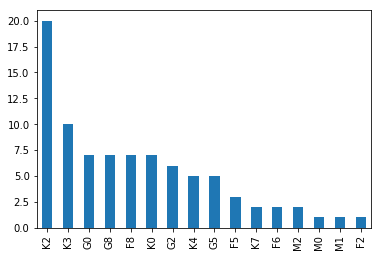

In [78]:
%matplotlib inline
spec_class_hist(specs,cluster)
s = list('OBAFGKM')

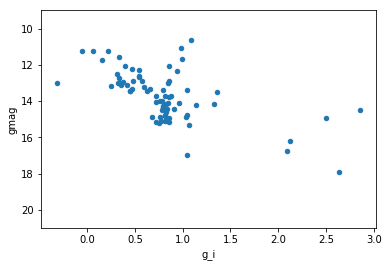

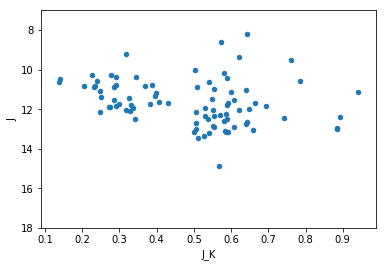

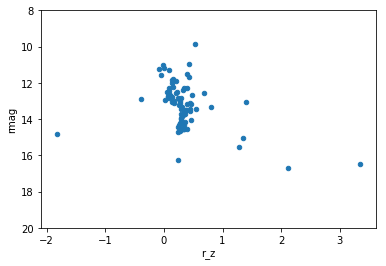

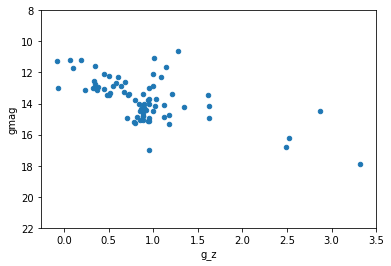

In [79]:
CMD(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(21,9))#19,5
CMD(specs,cluster,cid1='J',cid2='K',color='J_K',ylim=(18,7))#14,5
CMD(specs,cluster,cid1='rmag',cid2='zmag',color='r_z',ylim=(20,8))#18,5
CMD(specs,cluster,cid1='gmag',cid2='zmag',color='g_z',ylim=(22,8))#18,5


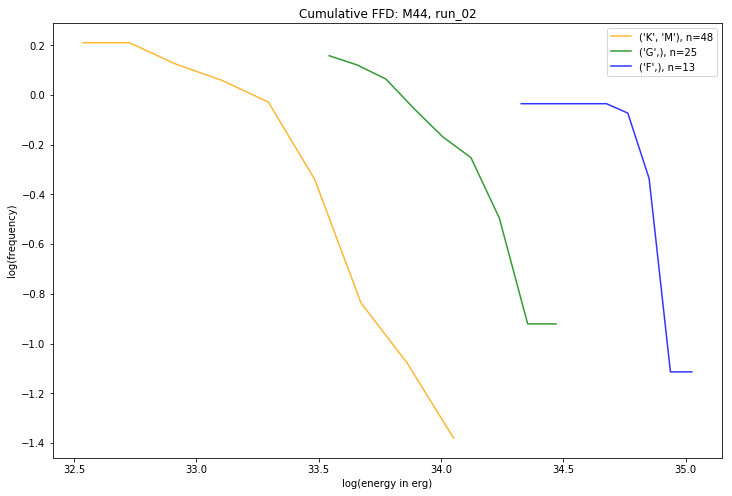

In [80]:
import time

def FFD(oid, cluster, test, specs,color='red'):
    myflares, flux, flares = import_flares(cluster, test, oid)
    bsc = specs.results.loc[oid]
    #    best_spec_class = optimize_spec_class_ID(oid,params,tab_spec)
    T = specs['T'].loc[oid]
    L_quiet = specs['L_quiet'].loc[oid]
    histAppa, edgesAppa = cum_hist(flares, flux, L_quiet,bins=5)
    binmids=[(x+edgesAppa[i])/2. for i,x in enumerate(edgesAppa[1:])]
    return plt.plot(binmids[1:],np.log10(histAppa[1:]),color=color,alpha=0.8,label='EPIC {}, T={}K'.format(oid,T))


def FFD_average(specs, cluster, test,class_='K7',color='red'):
    select = np.asarray([i for sublist in [specs[specs.results.str.contains(c)].index.values for c in class_] for i in sublist])

    #select = specs[specs.results.str.contains(class_)].index.values
    hist, edges = cum_hist_average(select, cluster, test, specs)
    binmids=[(x+edges[i])/2. for i,x in enumerate(edges[1:])]
    return plt.plot(binmids[1:],np.log10(hist[1:]),color=color,alpha=0.8,label='{}, n={}'.format(tuple(class_), len(select)))

def cum_hist_average(oid_list, cluster, test, specs):
    ED_, bins=[], 10
    for oid in oid_list:

        myflares, flux, flares = import_flares(cluster, test, oid)
       
        bsc = specs.results.loc[oid]
   
        T = specs['T'].loc[oid]
        L_quiet = specs['L_quiet'].loc[oid]
        s_s = flares[['istart_no_sys_no_thruster','istop_no_sys_no_thruster']].dropna()
        for i,row in s_s.iterrows():
            ed = ED(row['istart_no_sys_no_thruster'],row['istop_no_sys_no_thruster'],flux.time,flux.flux_model,flux.flux_gap)
            if (ed != 'nan') & (ed >0):
                ED_.append(np.log10(ed*24.*60.*60.*L_quiet))
    
    hist, edges=np.histogram(ED_, bins=bins)
    hist = np.flip(np.cumsum(np.flip(hist/oid_list.shape[0],axis=0)),axis=0)
    return hist, edges

plt.figure(figsize=(12,8))
plt.title('Cumulative FFD: {}, {}'.format(cluster,test))
FFD_average(specs, cluster, test,class_=['K','M'],color='orange')
FFD_average(specs, cluster, test,class_=['G'],color='green')
FFD_average(specs, cluster, test,class_=['F'],color='blue')

plt.legend()
plt.xlabel('log(energy in erg)')
plt.ylabel('log(frequency)')

plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/results/{1}/plots/{0}_{1}_cum_FFD.jpg'.format(cluster,test))


In [ ]:
plt.figure(figsize=(12,8))
plt.title('Cumulative FFD: {}'.format(cluster))

for oid in selectK.index.values:
    FFD(oid, cluster, test, specs, color='orange')
for oid in selectM.index.values:
    FFD(oid, cluster, test, specs, color='red')
plt.legend()
plt.xlabel('log(energy in erg)')
plt.ylabel('log(frequency)')
plt.show()